# Predicting Future Crime Rates with Facebook Prophet 

## Violent crime 

In [1]:
# importing necessary libraries and configurations
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

from fbprophet import Prophet
from fbprophet.plot import plot_plotly
from fbprophet.plot import add_changepoints_to_plot

plt.style.use("classic")
%matplotlib inline

In [10]:
# loading datasets
df = pd.read_csv("df_viol.csv")

In [11]:
# data cleaning and indexing
drop = ["latitude", "longitude"]

df.drop(drop, axis=1, inplace=True)
df.occurred_date = df.occurred_date.astype("datetime64")
df.set_index(["occurred_date"], inplace=True)
df.sort_index(inplace=True)

## Predicting crime rates with Facebook Prophet 

### Modeling the data as-is

INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.


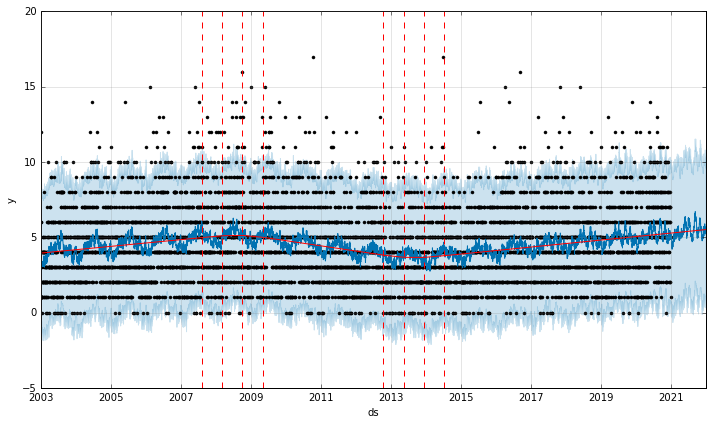

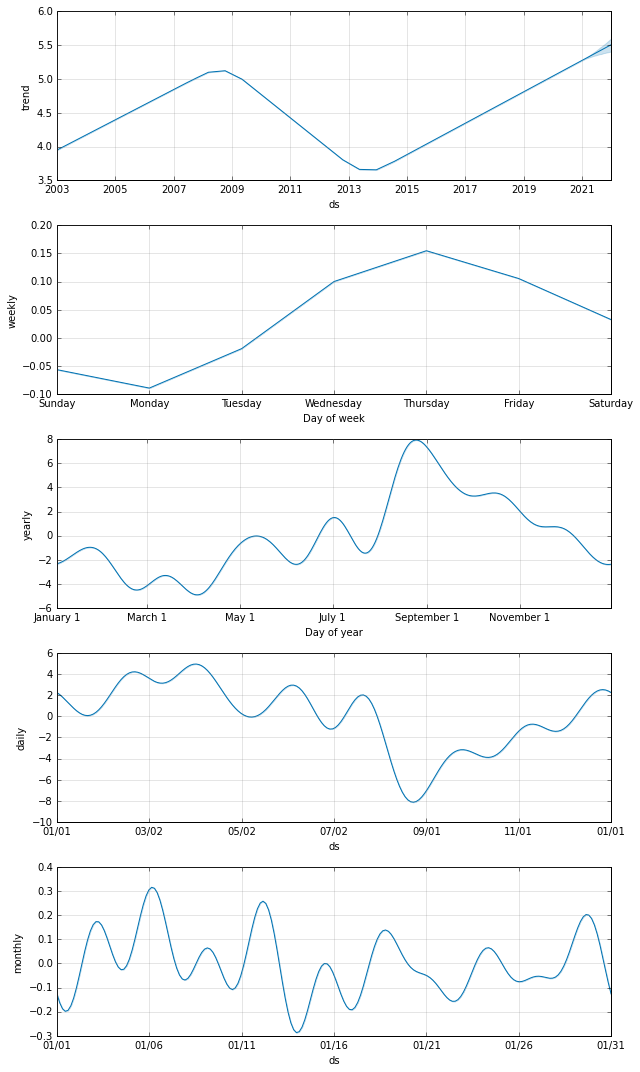

In [14]:
# Prepping to forecast
df_fbprophet = df.copy()
df_m = df_fbprophet.resample("D").size().reset_index()
df_m.columns = ["date", "daily_crime_count"]
df_m_final = df_m.rename(columns={"date": "ds", "daily_crime_count": "y"})
# df_m_final["y"] = np.log(df_m_final["y"])
df_m_final["y"] = pd.to_numeric(df_m_final["y"])
y = df_m_final["y"].to_frame()
y.index = df_m_final["ds"]
n = np.int(y.count())

# Fitting and configuring the model
m = Prophet(interval_width=0.95)
m.add_seasonality(name="monthly", period=30.5, fourier_order=10)
m.add_seasonality(name="weekly", period=52, fourier_order=10)
m.add_seasonality(name="daily", period=365, fourier_order=10)
m.fit(df_m_final)

future = m.make_future_dataframe(periods=365, freq="D")

forecast = m.predict(future)

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

fig2 = m.plot_components(forecast)

fig2_1 = plot_plotly(m, forecast)
fig2_1

In [15]:
# The forecast is 'log transformed', so we need to 'inverse' it back by using the exp
forecast_df_exp = np.exp(forecast[["yhat", "yhat_lower", "yhat_upper"]])
forecast_df_exp.index = forecast["ds"]

# Calculating MAPE error 
error = forecast_df_exp["yhat"] - y["y"]
MAPE_df = (error / y["y"]).abs().sum() / n * 100
round(MAPE_df, 2)

inf

### Mitigating outlier effects on moodel accuracy 

In [16]:
# Make another copy of the data frame as m2
df_prophet2 = df_m_final.copy()

# Define the Upper Control Limit and Lower Control Limit as 3 standard deviations from the mean
ucl = df_prophet2.mean() + df_prophet2.std() * 3
lcl = df_prophet2.mean() - df_prophet2.std() * 3

# display the number of outliers found
print(
    "Above 3 standard deviations: ",
    df_prophet2[df_prophet2["y"] > ucl["y"]]["y"].count(),
    "entries",
)
print(
    "Below 3 standard deviations: ",
    df_prophet2[df_prophet2["y"] < lcl["y"]]["y"].count(),
    "entries",
)

Above 3 standard deviations:  75 entries
Below 3 standard deviations:  0 entries


c:\users\robert\anaconda3\envs\fbprophet\lib\site-packages\ipykernel_launcher.py:5: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

c:\users\robert\anaconda3\envs\fbprophet\lib\site-packages\ipykernel_launcher.py:6: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.


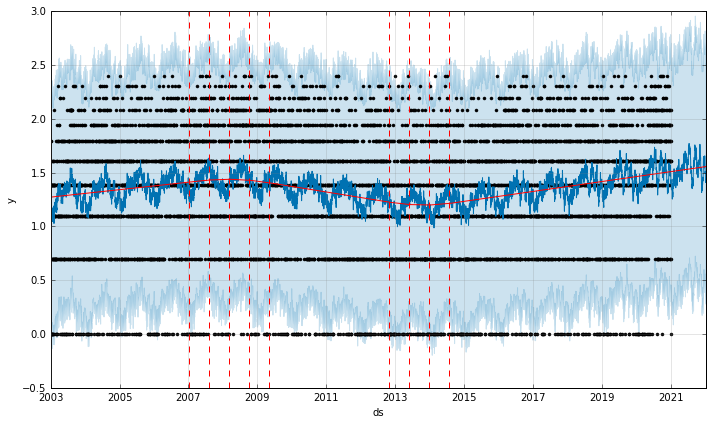

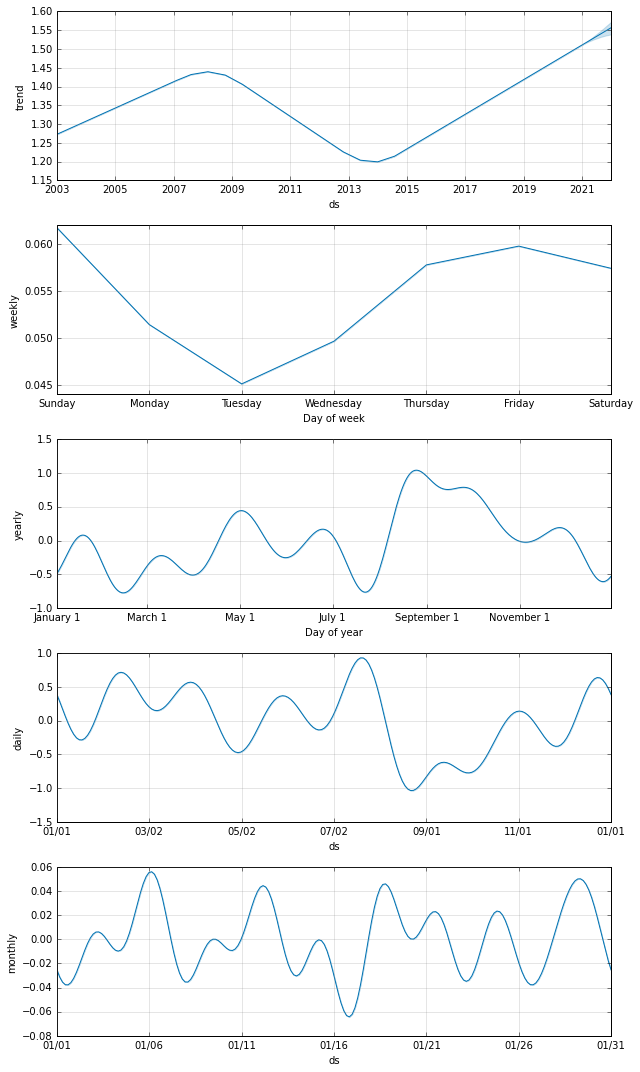

In [18]:
# Remove them by setting their value to None. Prophet says it can handle null values.
df_prophet2.loc[df_prophet2["y"] > ucl["y"], "y"] = None
df_prophet2.loc[df_prophet2["y"] < lcl["y"], "y"] = None

# Log transformation
# df_prophet2["y"] = np.log(df_prophet2["y"])
df_prophet2["y"] = pd.to_numeric(df_prophet2["y"])

# Run Prophet using model 2
m2 = Prophet(interval_width=0.95)
m2.add_seasonality(name="monthly", period=30.5, fourier_order=10)
m2.add_seasonality(name="weekly", period=52, fourier_order=10)
m2.add_seasonality(name="daily", period=365, fourier_order=10)
m2.fit(df_prophet2)

future = m2.make_future_dataframe(periods=365)

forecast_m2 = m2.predict(future)

fig_m2 = m2.plot(forecast_m2)
a = add_changepoints_to_plot(fig_m2.gca(), m2, forecast_m2)

fig2m2 = m2.plot_components(forecast_m2)

fig2_1m2 = plot_plotly(m2, forecast_m2)
fig2_1m2

In [19]:
# Re-inversing the forecast
forecast_m2_exp = np.exp(forecast_m2[["yhat", "yhat_lower", "yhat_upper"]])
forecast_m2_exp.index = forecast_m2["ds"]

# RecalculatinG MAPE error
error = forecast_m2_exp["yhat"] - y["y"]
MAPE_m2 = (error / y["y"]).abs().sum() / n * 100
round(MAPE_m2, 2)

inf